In [1]:
!pip -q install rdkit-pypi==2021.9.4

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.7 MB/s eta 0:00:0000:01


In [3]:
!pip install pysmiles

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.5 MB/s eta 0:00:00


In [4]:
import ast

import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import random
import matplotlib.pyplot as plt
from pysmiles import read_smiles
import pandas as pd
import logging
from tqdm import tqdm
import torch
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, GCNConv
from torch_geometric.utils import remove_self_loops, add_self_loops, degree
from torch_geometric.data import Data
import keras
from torch_geometric.loader import DataLoader
logging.getLogger('pysmiles').setLevel(logging.CRITICAL)  # Anything higher than warning
RDLogger.DisableLog("rdApp.*")

2024-07-14 22:53:40.789684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 22:53:40.789809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 22:53:40.945204: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Download the ZINC dataset
We are going to train models to predict the logP variable from the graph of the molecule with GNN and ECFP

In [5]:
csv_path = keras.utils.get_file(
    "/kaggle/working/250k_rndm_zinc_drugs_clean_3.csv",
    "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv",
)

df = pd.read_csv("/kaggle/working/250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()


22606589/22606589 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


### logP histogram

(array([5.00000e+00, 6.40000e+01, 6.73000e+02, 4.92300e+03, 2.28880e+04,
        6.90740e+04, 1.03614e+05, 4.62210e+04, 1.97700e+03, 1.60000e+01]),
 array([-6.8762 , -5.36337, -3.85054, -2.33771, -0.82488,  0.68795,
         2.20078,  3.71361,  5.22644,  6.73927,  8.2521 ]),
 <BarContainer object of 10 artists>)

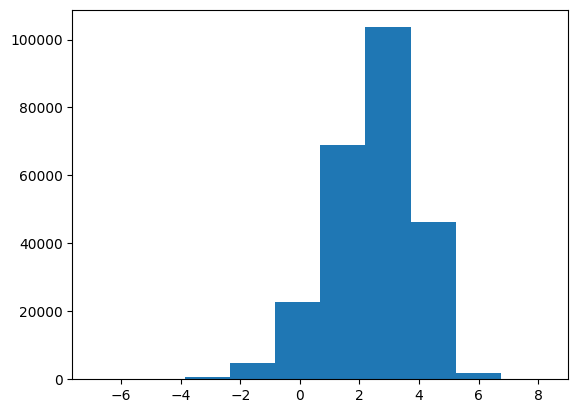

In [6]:
plt.hist(df['logP'])

## Molecule example

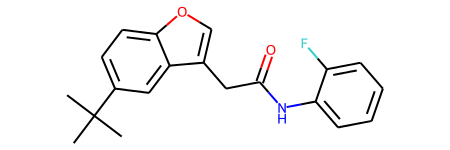

In [7]:
m = Chem.MolFromSmiles(df['smiles'][0])
m

## Process the data to pass the graphs to networkx and then to PyTorch
Code from https://github.com/SullyChen/Molecular-Solubility-with-PyTorch-Geometric/blob/main/Molecular%20Solubility.ipynb

In [8]:

X_smiles = list(df['smiles']) #get smiles strings from file
Y = np.asarray(df['logP']) #get logP values from file

elements = ['K', 'Y', 'V', 'Sm', 'Dy', 'In', 'Lu', 'Hg', 'Co', 'Mg',
            'Cu', 'Rh', 'Hf', 'O', 'As', 'Ge', 'Au', 'Mo', 'Br', 'Ce', 
            'Zr', 'Ag', 'Ba', 'N', 'Cr', 'Sr', 'Fe', 'Gd', 'I', 'Al', 
            'B', 'Se', 'Pr', 'Te', 'Cd', 'Pd', 'Si', 'Zn', 'Pb', 'Sn', 
            'Cl', 'Mn', 'Cs', 'Na', 'S', 'Ti', 'Ni', 'Ru', 'Ca', 'Nd', 
            'W', 'H', 'Li', 'Sb', 'Bi', 'La', 'Pt', 'Nb', 'P', 'F', 'C']

#convert element to a one-hot vector of dimension len(elements)
def element_to_onehot(element):
    out = []
    for i in range(0, len(element)):
        v = np.zeros(len(elements))
        v[elements.index(element[i])] = 1.0
        out.append(v)
    return np.asarray(out)

#process SMILES strings into graphs
nodes = []
edge_index = []
for smiles in tqdm(X_smiles):
    try:
        G = read_smiles(smiles, explicit_hydrogen=True)
        feature = element_to_onehot(np.asarray(G.nodes(data='element'))[:, 1])
        edges = np.asarray(G.edges)
        index = np.asarray([edges[:,0], edges[:,1]]) #reshape indices into shape [2, -1]
        nodes.append(feature)
        edge_index.append(index)
    except:
        pass

100%|██████████| 249455/249455 [07:06<00:00, 584.60it/s]


Graph of the 1st molecule

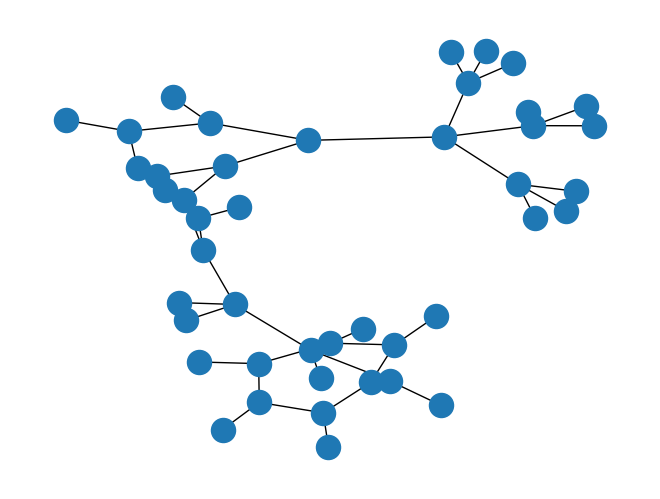

In [9]:
nx.draw(read_smiles(X_smiles[0], explicit_hydrogen=True))

In [10]:
#Generate Data objects
data = list()

#process graphs into torch_geometric Data objects
for i in tqdm(range(0, len(nodes))):
    x = torch.tensor(nodes[i], dtype=torch.float) #convert node features into torch tensor
    edges = torch.tensor(edge_index[i], dtype=torch.int64) #convert edge index into torch tensor
    y = torch.tensor([Y[i]], dtype=torch.float) #change shape of label and convert to tensor
    data.append(Data(x=x,edge_index=edges, y=y)) #add the Data object to the list of data

100%|██████████| 249455/249455 [00:20<00:00, 12342.88it/s]


### We define the train-test split, which will later be used for the ECFP

In [11]:
def random_permutation_with_seed(list_to_permute, seed):
    indices = list(range(len(list_to_permute)))
    random.seed(seed)
    random.shuffle(indices)
    return indices

def apply_permutation(original_list, permutation):
    # Apply the permutation to the original list
    permuted_list = [original_list[i] for i in permutation]
    return permuted_list
permutation = random_permutation_with_seed(data, seed=42)

data_perm = apply_permutation(data, permutation)
train = data_perm[:int(len(data_perm)*0.8)] #train set
test = data_perm[int(len(data_perm)*0.8):] #val set

### We define the GNN

In [12]:
#define the message passing network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(61, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.conv4 = GCNConv(32, 32)
        self.lin1 = Linear(32, 16)
        self.lin2 = Linear(16, 1)

    def forward(self, data):
        x, edge_index= data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        
        x = torch.sum(x, dim=0)
        x = self.lin1(x)
        x = F.relu(x)
        
        x = self.lin2(x)
        

        return x


### We train the GNN
only 1 epoch because it takes a long time

I use batch_size=1 because if not, it works badly due to something about pytorch geometry (it takes everything as 1 single graph and does not give the same results)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use CUDA if available
model = Net().to(device) #create network and send to the device memory
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #use Adam optimizer
MSE = torch.nn.MSELoss() #define loss

In [14]:


# Assuming `train` is a list of PyTorch Geometric `Data` objects
batch_size = 1

# DataLoader for batching the training data
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

model.train()  # Set model to training mode
for epoch in range(1):  # Run for epochs of training
    sum_loss = 0  # Used to compute average loss in an epoch

    for batch in tqdm(train_loader):  # Go over each batch
        batch = batch.to(device)  # Send batch to device
        optimizer.zero_grad()  # Zero gradients
        out = model(batch)  # Evaluate batch

        # Compute mean squared error loss
        loss = MSE(out, batch.y.to(device))
        sum_loss += loss.item() * batch.num_graphs  # Multiply by batch size to get total loss for the batch

        loss.backward()  # Compute gradients
        optimizer.step()  # Apply optimization

    # Compute average loss for the epoch
    avg_loss = sum_loss / len(train)
    
    print(f'Epoch: {epoch:03d}, Average loss: {avg_loss:.5f}')

100%|██████████| 199564/199564 [22:11<00:00, 149.91it/s]

Epoch: 000, Average loss: 1.13344


### We evaluate the GNN

In [15]:
batch_size = 1
# Calculate loss for the test data and collect predictions
model.eval()  # Set model to evaluation mode
test_loss = 0  # Used to compute average test loss
all_preds = []
all_targets = []

test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)
with torch.no_grad():  # Disable gradient computation
    for batch in tqdm(test_loader):  # Go over each test batch
        batch = batch.to(device)  # Send batch to device
        out = model(batch)  # Evaluate batch
        # Collect predictions and actual values
        all_preds.append(out.cpu())
        all_targets.append(batch.y.cpu())

        # Compute mean squared error loss
        loss = MSE(out, batch.y.to(device))
        test_loss += loss.item() * batch.num_graphs  # Multiply by batch size to get total loss for the batch

# Compute average test loss
avg_test_loss = test_loss / len(test)

print(f'Average test loss: {avg_test_loss:.5f}')

# Convert lists to tensors
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)




100%|██████████| 49891/49891 [03:31<00:00, 235.70it/s]


Average test loss: 0.93917


### Graph: actual logP vs prediction

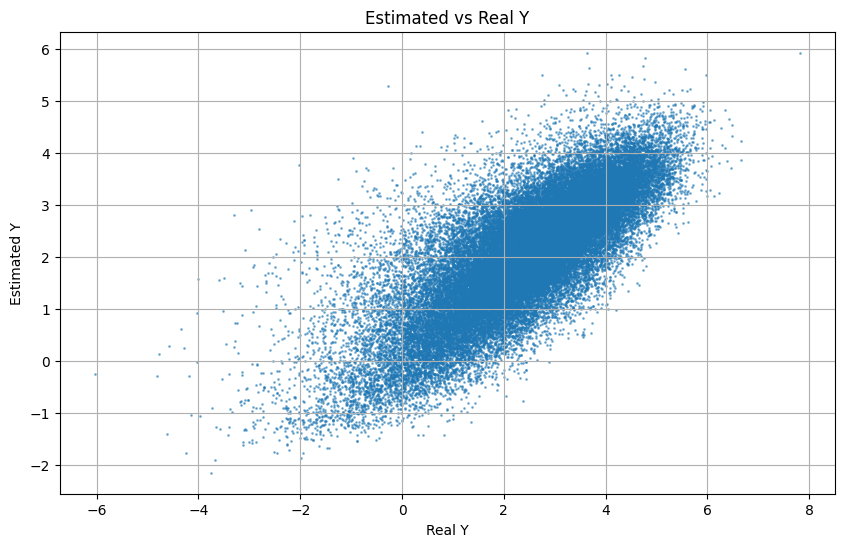

In [16]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(all_targets.numpy(), all_preds.numpy(), s=1, alpha=0.5)  # Set `s` parameter to make points smaller
plt.xlabel('Real Y')
plt.ylabel('Estimated Y')
plt.title('Estimated vs Real Y')
plt.grid(True)
plt.show()

### Function to generate ECFP with the RDKit library
https://www.blopig.com/blog/2022/11/how-to-turn-a-smiles-string-into-an-extended-connectivity-fingerprint-using-rdkit/

In this case we use ECFP of diameter 4 and pooling of dimension 1024

In [17]:
import numpy as np
from rdkit.Chem import AllChem
# define function that transforms SMILES strings into ECFPs
def ECFP_from_smiles(smiles,
                     R = 4,
                     L = 2**10,
                     use_features = False,
                     use_chirality = False):
    """
    Inputs:
    
    - smiles ... SMILES string of input compound
    - R ... maximum radius of circular substructures
    - L ... fingerprint-length
    - use_features ... if false then use standard DAYLIGHT atom features, if true then use pharmacophoric atom features
    - use_chirality ... if true then append tetrahedral chirality flags to atom features
    
    Outputs:
    - np.array(feature_list) ... ECFP with length L and maximum radius R
    """
    
    molecule = AllChem.MolFromSmiles(smiles)
    feature_list = AllChem.GetMorganFingerprintAsBitVect(molecule,
                                                                       radius = R,
                                                                       nBits = L,
                                                                       useFeatures = use_features,
                                                                       useChirality = use_chirality)
    return np.array(feature_list)

In [18]:
ECFPList=[ECFP_from_smiles(smile) for smile in df['smiles']]

In [19]:
ECFP_perm = apply_permutation(ECFPList,permutation)

In [20]:
ECFP_train = np.array(ECFP_perm[:int(len(ECFP_perm)*0.8)]) #train set
ECFP_test = np.array(ECFP_perm[int(len(ECFP_perm)*0.8):]) #val set

In [21]:
logP_perm = apply_permutation(df["logP"].values.tolist(),permutation)

In [22]:
logP_train = np.array(logP_perm[:int(len(logP_perm)*0.8)]) #train set
logP_test = np.array(logP_perm[int(len(logP_perm)*0.8):]) #val set

## We use LightGBM to predict logP from ECFP



In [ ]:
del train_loader
del test_loader
del train
del test
del data_perm


In [24]:
import gc
gc.collect()

4399

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


train_data = lgb.Dataset(ECFP_train, label=logP_train)
test_data = lgb.Dataset(ECFP_test, label=logP_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

num_round = 1000
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

y_pred = model.predict(ECFP_test)

mse = mean_squared_error(logP_test, y_pred)
print(f"Mean Squared Error: {mse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.930946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 199564, number of used features: 1024
[LightGBM] [Info] Start training from score 2.455976
Mean Squared Error: 0.3533873093304823


### The error is much lower with ECFP

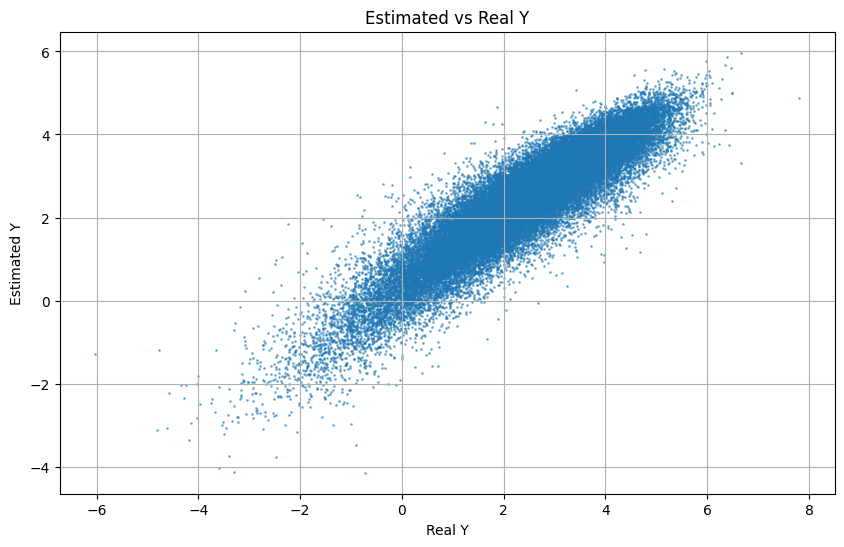

In [29]:
# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(logP_test, y_pred, s=1, alpha=0.5)  # Set `s` parameter to make points smaller
plt.xlabel('Real Y')
plt.ylabel('Estimated Y')
plt.title('Estimated vs Real Y')
plt.grid(True)
plt.show()

# Conclusion:

Here you can see the paperswithcode leaderboard with the ZINC dataset

https://paperswithcode.com/sota/graph-regression-on-zinc-500k

The objective is the MAE of logP-SAS- (number of cycles of >=6 atoms), here only the MSE of the logP variable was used

It can be seen that the error varies greatly depending on the model used.

Even though the objective is different, it can be seen that some models far exceed the performance of the GNN and ECFP+LGBM of this notebook.

Some things that could be improved in the GNN are:

--Increase batch_size or use gradient accumulation

--Change the architecture

--More epochs

--Change optimizer hyperparameters

